In [1]:
images=[]
lesions=[]
from skimage.io import imread
import os

root='/kaggle/input/ph2dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
  if root.endswith('_Dermoscopic_Image'):
    images.append(imread(os.path.join(root, files[0])))
  if root.endswith('_lesion'):
    lesions.append(imread(os.path.join(root, files[0])))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from skimage.transform import resize
size=(256, 256)
X=[resize (x, size, mode='constant', anti_aliasing=True,) for x in images]
Y=[resize (y, size, mode='constant', anti_aliasing=False,)> 0.5 for y in lesions ]

In [3]:
import numpy as np
X=np.array(X, np.float32)
Y=np.array(Y, np.float32)
print(f'loaded {len(X)} images')

loaded 200 images


In [4]:
len(lesions)

200

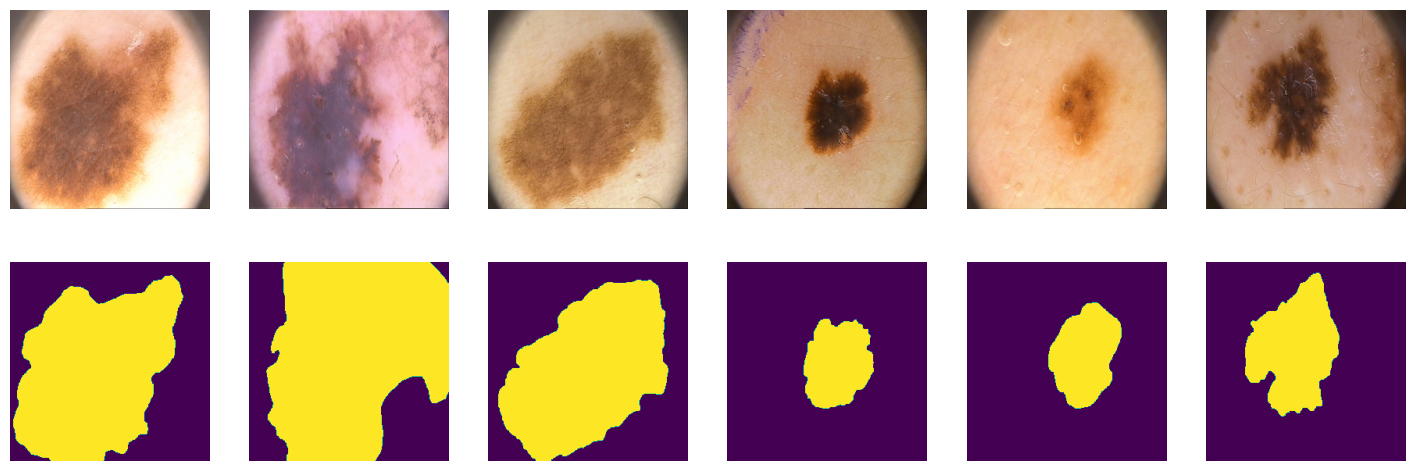

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [6]:
ix=np.random.choice(len(X), len(X), False)
tr, val, ts=np.split(ix, [100, 150])

In [7]:
print(len(tr), len(val), len(ts))

100 50 50


In [8]:
from torch.utils.data import DataLoader
batch_size=25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [9]:
import torch
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 6)

In [11]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(nn.BatchNorm2d(num_features=3),
                                       nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(2, return_indices=True)

        self.enc_conv1 = nn.Sequential(nn.BatchNorm2d(num_features=64),
                                       nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        
        self.enc_conv2 = nn.Sequential(nn.BatchNorm2d(num_features=128),
                                       nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        
        self.enc_conv3 = nn.Sequential(nn.BatchNorm2d(num_features=256),
                                       nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                       nn.ReLU())
        self.pool3 =  nn.MaxPool2d(2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.BatchNorm2d(num_features=512),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                                       nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2)
        self.dec_conv0 = nn.Sequential(nn.BatchNorm2d(num_features=512),
                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.upsample1 = nn.MaxUnpool2d(2)
        self.dec_conv1 = nn.Sequential(nn.BatchNorm2d(num_features=256),
                                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.upsample2 = nn.MaxUnpool2d(2)
        self.dec_conv2 = nn.Sequential(nn.BatchNorm2d(num_features=128),
                                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.ReLU())
        
        self.upsample3 = nn.MaxUnpool2d(2)
        self.dec_conv3 = nn.Sequential(nn.BatchNorm2d(num_features=64),
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)#,
                                       #nn.Sigmoid()
                                       )

    def forward(self, x):
        # encoder
        # индексы нужны для MaxUnpool
        # индексы MaxPool-0 соотвтетствуют индексам MaxUnpool-3
        # (так происходит из-за U-образной архитектуры)
        e0, indices3 = self.pool0(self.enc_conv0(x))
        e1, indices2 = self.pool1(self.enc_conv1(e0))
        e2, indices1 = self.pool2(self.enc_conv2(e1))
        e3, indices0 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices0))
        d1 = self.dec_conv1(self.upsample1(d0, indices1))
        d2 = self.dec_conv2(self.upsample2(d1, indices2))
        d3 = self.dec_conv3(self.upsample2(d2, indices3))
        return d3

In [12]:
def iou_pytorch(outputs:torch.Tensor, labels:torch.Tensor):
    outputs=outputs.squeeze(1).byte()
    labels=labels.squeeze(1).byte()
    SMOOTH=1e-8
    intersection=(outputs&labels).float().sum((1,2))
    union=(outputs|labels).float().sum((1,2))

    iou=(intersection+SMOOTH)/(union+SMOOTH)

    thresholded=torch.clamp(20*(iou-0.5), 0, 10).ceil()/10

    return thresholded

In [13]:
def bce_loss(y_real, y_pred):
    return ((y_pred-y_real*y_pred+torch.log(1+torch.exp(-y_pred)))).mean()

In [14]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)
    
    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        print('loss: %f' % avg_loss)
        train_loss.append(avg_loss)
        
        scheduler.step()
        
        # show intermediate results
        eavg_loss = 0
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
            eavg_loss += loss.item() / len(data_val)
        val_loss.append(eavg_loss)
        
        with torch.no_grad():
            Y_hat = F.sigmoid(model(X_val)) > 0.5  # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0].cpu(), cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
            plt.subplot(3, 6, k+13)
            plt.imshow(np.rollaxis(Y_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Truth')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return train_loss, val_loss

In [15]:
def predict(model, data):
    model.eval()
    Y_pred=[model(X_batch) for X_batch, _ in data]

In [16]:
def score_model(model, metric, data):
    model.eval()
    scores=0
    for X_batch, Y_label in data:
        X_batch=X_batch.to(device)
        Y_label= Y_label.to(device)
        Y_pred=F.sigmoid(model(X_batch)) > 0.5
        scores+=metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)


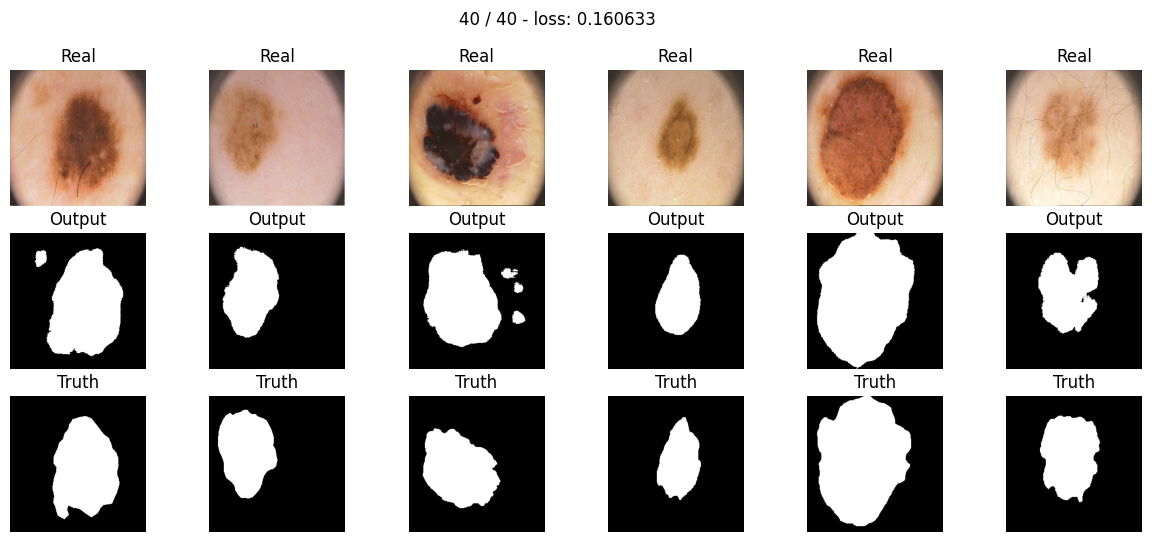

In [17]:
model=SegNet().cuda(device)

max_epochs=40
optimizer=optim.Adam(model.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
model_tl, model_vl=train(model, optimizer, scheduler, bce_loss, max_epochs, data_tr, data_val)

In [18]:
model_s=score_model(model, iou_pytorch, data_val)

In [19]:
def dice_loss(y_real, y_pred):
    y_pred=F.sigmoid(y_pred)
    eps=1e-8

    num=(2*y_real*y_pred).sum()
    den=((y_real+y_pred).sum()+eps)*256*256
    res=1-(num/den)
    return res

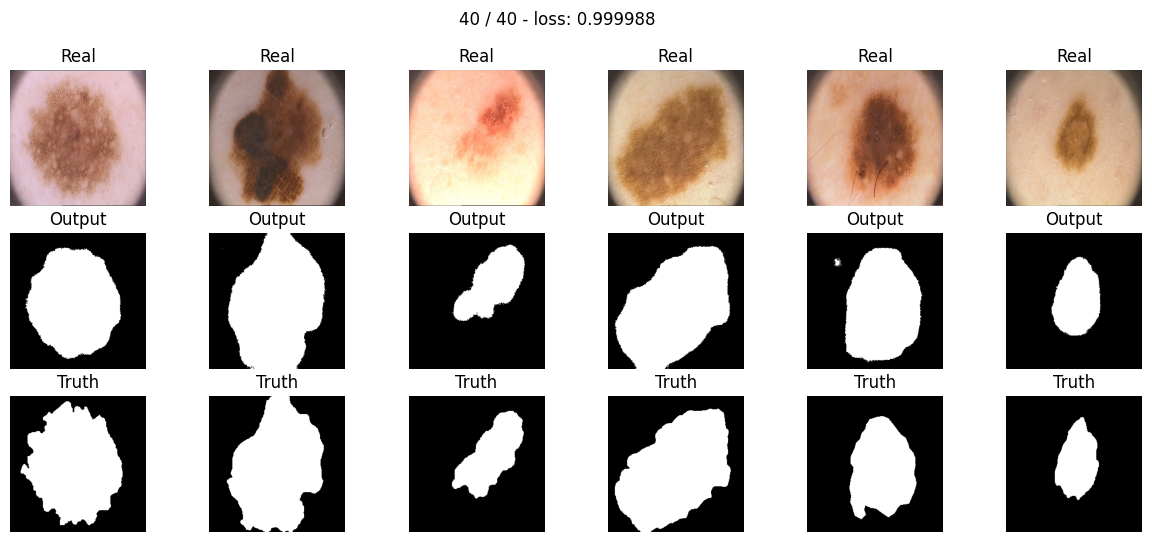

In [20]:
model_dice=SegNet().to(device)

max_epochs=40
optimizer=optim.Adam(model_dice.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
model_dice_tl, model_dice_vl=train(model_dice, optimizer, scheduler, dice_loss, max_epochs, data_tr, data_val)

In [21]:
model_dice_s=score_model(model_dice, iou_pytorch, data_val)

In [22]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=2):
    y_pred=torch.clamp(y_pred, eps, 1-eps)
    loss=-(((1-F.sigmoid(y_pred))**gamma)*y_real* torch.log(F.sigmoid(y_pred))+
         (F.sigmoid(y_pred)** gamma) * (1-y_real) * torch.log(1-F.sigmoid(y_pred)))
    return loss.mean()

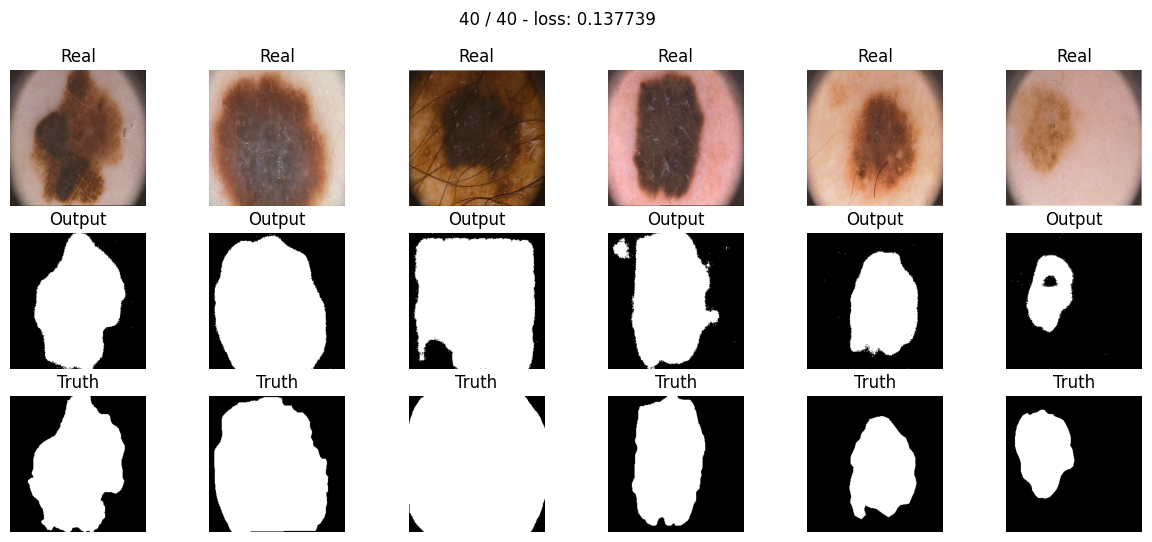

In [23]:
model_focal=SegNet().to(device)

max_epochs = 40
optimizer=optim.Adam(model_focal.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
model_focal_tl, model_focal_vl=train(model_focal, optimizer, scheduler, focal_loss, max_epochs, data_tr, data_val)

In [24]:
model_focal_s=score_model(model_focal, iou_pytorch, data_val)

In [25]:
def bce_with_smoothing_loss(y_real, y_pred, eps=1e-8, smoothing=1e-2, gamma=2):
    y_pred=torch.clamp(y_pred, eps, 1-eps)
    y_real_1=(1-smoothing)* y_real+smoothing*torch.rand(y_real.shape, device=device)
    y_real_2=(1-smoothing)*(1-y_real)+smoothing*torch.rand(y_real.shape, device=device)
    loss=-(y_real_1*torch.log(F.sigmoid(y_pred))+
         y_real_2*torch.log(1-F.sigmoid(y_pred)))
    return loss.mean()

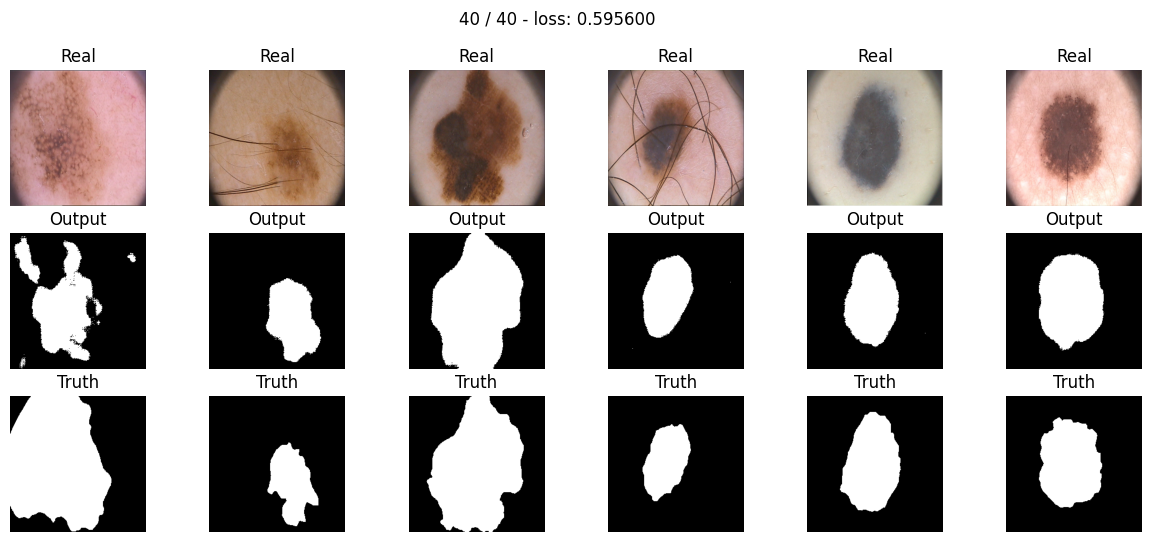

In [26]:
model_ls=SegNet().to(device)

max_epochs=40
optimizer=optim.Adam(model_ls.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
model_ls_tl, model_ls_vl=train(model_ls, optimizer, scheduler, bce_with_smoothing_loss, max_epochs, data_tr, data_val)

In [27]:
model_ls_s=score_model(model_ls, iou_pytorch, data_val)

In [28]:
class UNet(nn.Module): #https://arxiv.org/pdf/1505.04597.pdf #https://arxiv.org/abs/1505.04597
    def __init__(self):
        super().__init__()

        self.enc_conv0=nn.Sequential(nn.BatchNorm2d(num_features=3),
                                 nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
        self.pool0=nn.MaxPool2d(2, return_indices=True)

        self.enc_conv1=nn.Sequential(nn.BatchNorm2d(64),
                                 nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
        self.pool1=nn.MaxPool2d(2, return_indices=True)

        self.enc_conv2=nn.Sequential(nn.BatchNorm2d(128),
                                 nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
        self.pool2=nn.MaxPool2d(2, return_indices=True)

        self.enc_conv3=nn.Sequential(nn.BatchNorm2d(256),
                                  nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
                                  nn.ReLU())
        self.pool3=nn.MaxPool2d(2, return_indices=True)

    #bottleneck
        self.bottleneck_conv=nn.Sequential(nn.BatchNorm2d(num_features=512),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                                       nn.ReLU())
    
    #decoder
        self.upsample0=nn.MaxUnpool2d(2)
        self.dec_conv0=nn.Sequential(nn.BatchNorm2d(num_features=1024),
                                 nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
    
        self.upsample1=nn.MaxUnpool2d(2)
        self.dec_conv1=nn.Sequential(nn.BatchNorm2d(num_features=512),
                                 nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
    
        self.upsample2=nn.MaxUnpool2d(2)
        self.dec_conv2=nn.Sequential(nn.BatchNorm2d(num_features=256),
                                 nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
    
        self.upsample3=nn.MaxUnpool2d(2)
        self.dec_conv3=nn.Sequential(nn.BatchNorm2d(num_features=128),
                                 nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1, padding_mode='reflect'))
    
    def forward(self, x):
    #encoder
        e0=self.enc_conv0(x)
        p0,indices0=self.pool0(e0)
        e1=self.enc_conv1(p0)
        p1, indices1=self.pool1(e1)
        e2=self.enc_conv2(p1)
        p2, indices2=self.pool2(e2)
        e3=self.enc_conv3(p2)
        p3, indices3=self.pool3(e3)

    #bottleneck
        b=self.bottleneck_conv(p3)
    
    #decoder
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b, indices3)), axis=1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0, indices2)), axis=1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1, indices1)), axis=1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2, indices0)), axis=1))
        return d3


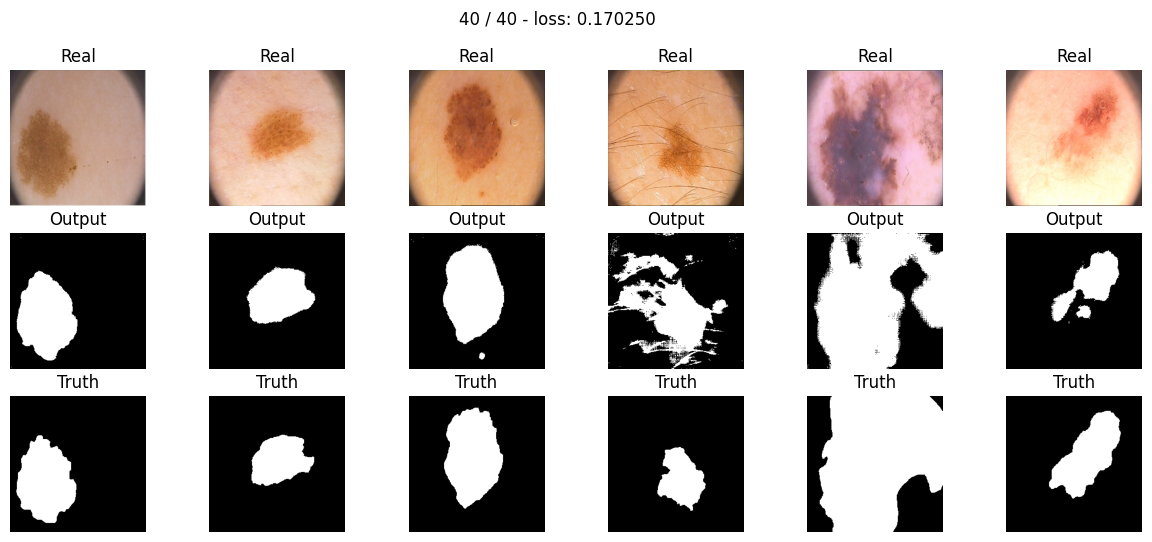

In [29]:
unet_model=UNet().to(device)

max_epochs=40
optimizer=optim.Adam(unet_model.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
unet_model_tl, unet_model_vl=train(unet_model, optimizer, scheduler, bce_loss, max_epochs, data_tr, data_val)

In [30]:
unet_model_s=score_model(unet_model, iou_pytorch, data_val)

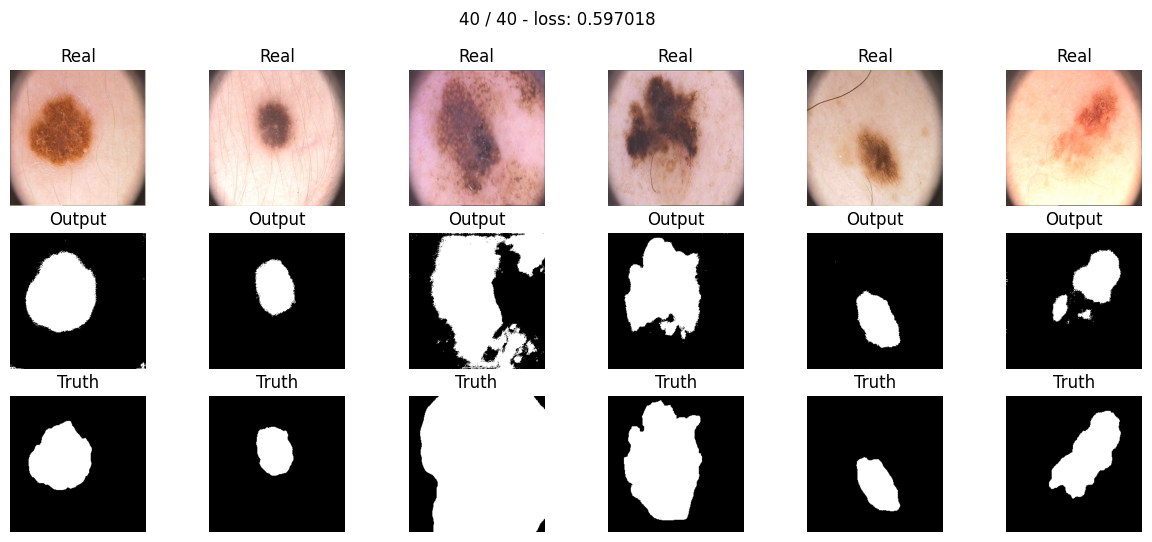

In [31]:
unet_dice_model=UNet().to(device)

max_epochs=40
optimizer=optim.Adam(unet_dice_model.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
unet_dice_model_tl, unet_dice_model_vl=train(unet_dice_model, optimizer, scheduler, bce_with_smoothing_loss, max_epochs, data_tr, data_val)

In [32]:
unet_dice_model_s=score_model(unet_dice_model, iou_pytorch, data_val)

In [33]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
    #encoder
        self.enc_conv0=nn.Sequential(nn.BatchNorm2d(num_features=3),
                                 nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
        self.pool0=nn.MaxPool2d(2)

        self.enc_conv1=nn.Sequential(nn.BatchNorm2d(num_features=64),
                                 nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
        self.pool1=nn.MaxPool2d(2)

        self.enc_conv2=nn.Sequential(nn.BatchNorm2d(num_features=128),
                                 nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
        self.pool2=nn.MaxPool2d(2)

        self.enc_conv3=nn.Sequential(nn.BatchNorm2d(num_features=256),
                                 nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
        self.pool3=nn.MaxPool2d(2)

    #bottleneck
        self.bottleneck_conv=nn.Sequential(nn.BatchNorm2d(num_features=512),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1),
                                       nn.ReLU())
    
    #decoder
        self.upsample0=nn.Upsample(scale_factor=2)
        self.dec_conv0=nn.Sequential(nn.BatchNorm2d(num_features=1024),
                                 nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
    
        self.upsample1=nn.Upsample(scale_factor=2)
        self.dec_conv1=nn.Sequential(nn.BatchNorm2d(num_features=512),
                                 nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
    
        self.upsample2=nn.Upsample(scale_factor=2)
        self.dec_conv2=nn.Sequential(nn.BatchNorm2d(num_features=256),
                                 nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1, padding_mode='reflect'),
                                 nn.ReLU())
    
        self.upsample3=nn.Upsample(scale_factor=2)
        self.dec_conv3=nn.Sequential(nn.BatchNorm2d(num_features=128),
                                 nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1, padding_mode='reflect'))
    
    def forward(self, x):
      #encoder
        e0=self.enc_conv0(x)
        p0=self.pool0(e0)
        e1=self.enc_conv1(p0)
        p1=self.pool1(e1)
        e2=self.enc_conv2(p1)
        p2=self.pool2(e2)
        e3=self.enc_conv3(p2)
        p3=self.pool3(e3)

      #bottleneck
        b=self.bottleneck_conv(p3)

      #decoder
        d0=self.dec_conv0(torch.cat((e3, self.upsample0(b)), axis=1))
        d1=self.dec_conv1(torch.cat((e2, self.upsample1(d0)), axis=1))
        d2=self.dec_conv2(torch.cat((e1, self.upsample2(d1)), axis=1))
        d3=self.dec_conv3(torch.cat((e0, self.upsample3(d2)), axis=1))
        return d3

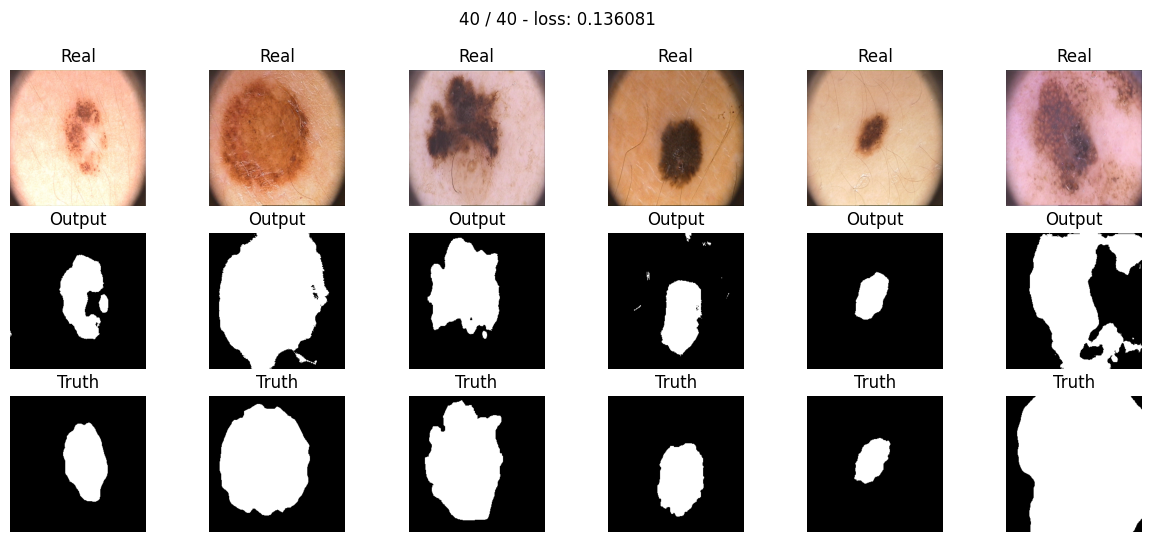

In [34]:
unet2_model=UNet2().to(device)

max_epochs=40
optimizer=optim.Adam(unet2_model.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
unet2_model_tl, unet2_model_vl=train(unet2_model, optimizer, scheduler, bce_loss, max_epochs, data_tr, data_val)

In [35]:
unet2_model_s=score_model(unet2_model, iou_pytorch, data_val)

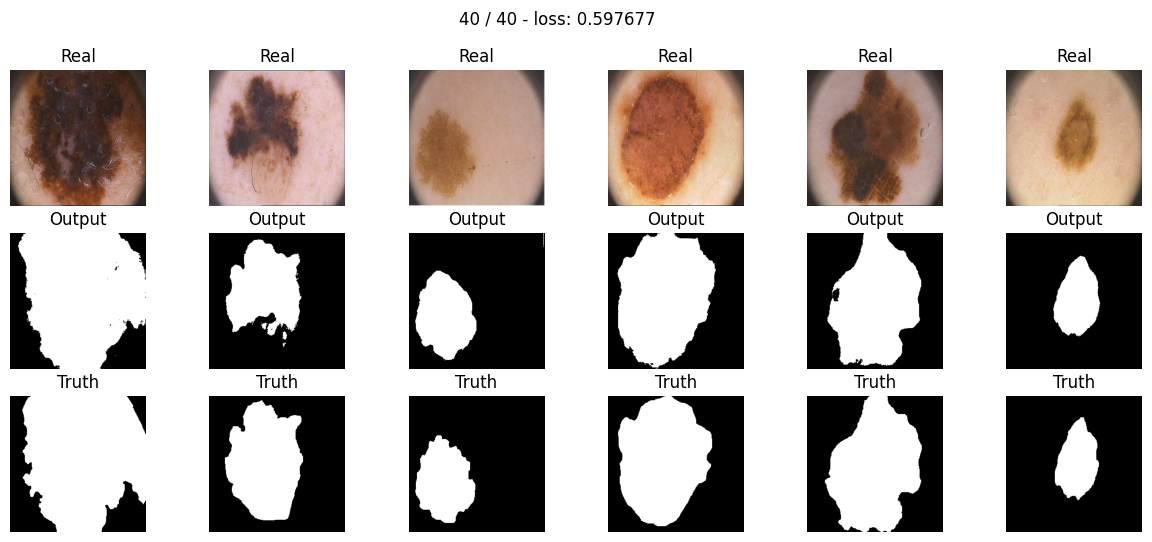

In [36]:
unet2_dice_model=UNet2().to(device)

max_epochs=40
optimizer=optim.Adam(unet2_dice_model.parameters(), lr=3e-4)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10)
unet2_model_dice_tl, unet2_model_dice_vl=train(unet2_dice_model, optimizer, scheduler, bce_with_smoothing_loss, max_epochs, data_tr, data_val)

In [37]:
unet2_model_dice_s=score_model(unet2_dice_model, iou_pytorch, data_val)

Отчет


Были внесены следующие изменения в трейнлуп: добавлен scheduler, добавлена аккумуляция лоссов для тренировочной и валидационной части в каждой из эпох, добавлено отображение реальной маски.

В качестве кастомного лосса был реализован BCE loss with label smoothing. U-net строилась с двумя разными методами апмемплинга (MaxUnpooling и NN), для лоссов BCE и BCE with smoothing loss. Тесты проводились в аналогичных спецификациях гиперпараметров. По результатам экспериментов победила спецификация U-net со стандартным BCE loss . Причиной этого является тот факт, что для эффективной сходимости при использовании альтернативных лоссов нужно больше итераций без уменьшения learning rate'a, а также другое значение самого learning rate'a. Предложенные авторами курса варианты сетей SegNet и U-net с малым количеством сверточных слоев в значительной мере подвержены переобучению. При рассмотрении маски вероятностей классов пикселей (но не самой маски классов), становится ясно, что сеть зачастую (благодаря проблемным случаям) не способна достичь состояния, когда с вероятностью ~100% отделяет круглую рамку от картинки и при этом с вероятностью ~100% выделяет все фрагменты изображений родинок, Вместо этого, происходит колебания между состояниями ~100% выделения круглых рамок (но с уменьшением вероятности верного выделения некоторых фрагментов родинок) и ~100% выделения родинок (но с уменьшением вероятности верного выделения некоторых фрагментов рамок). Этот факт косвенно указывает на недостаточную глубину сети, что влечет за собой переобучение после некоторого этапа обучения. Также этот факт подтверждает случайная ошибка: первоначально меной вместо ботлнек свертки 1х1 использовалась свертка 3х3 с паддингом 1, что позволяло достичь больших результатов по метрике. U-net в данной спецификации тоже достаточно мал, что обуславливает схожесть его свойств с SegNet'ом и схожие значения метрик.

Text(0.5, 1.0, 'SegNet with BCE loss, iou score: 0.6739999949932098')

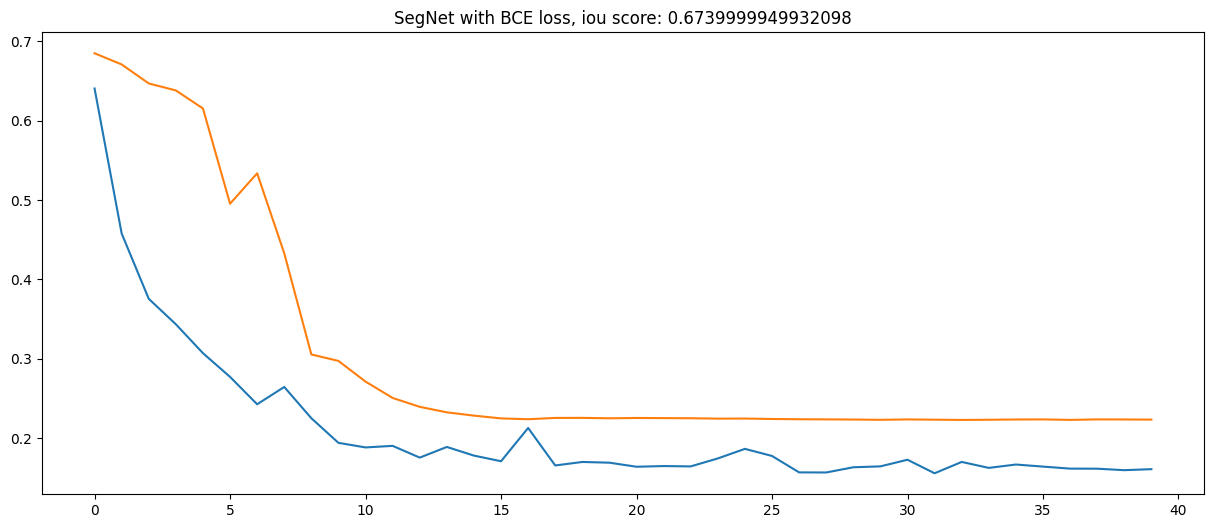

In [38]:
plt.plot(model_tl)
plt.plot(model_vl)
plt.title(f'SegNet with BCE loss, iou score: {model_s}')

Text(0.5, 1.0, 'SegNet with Dice loss, iou score: 0.5760000050067902')

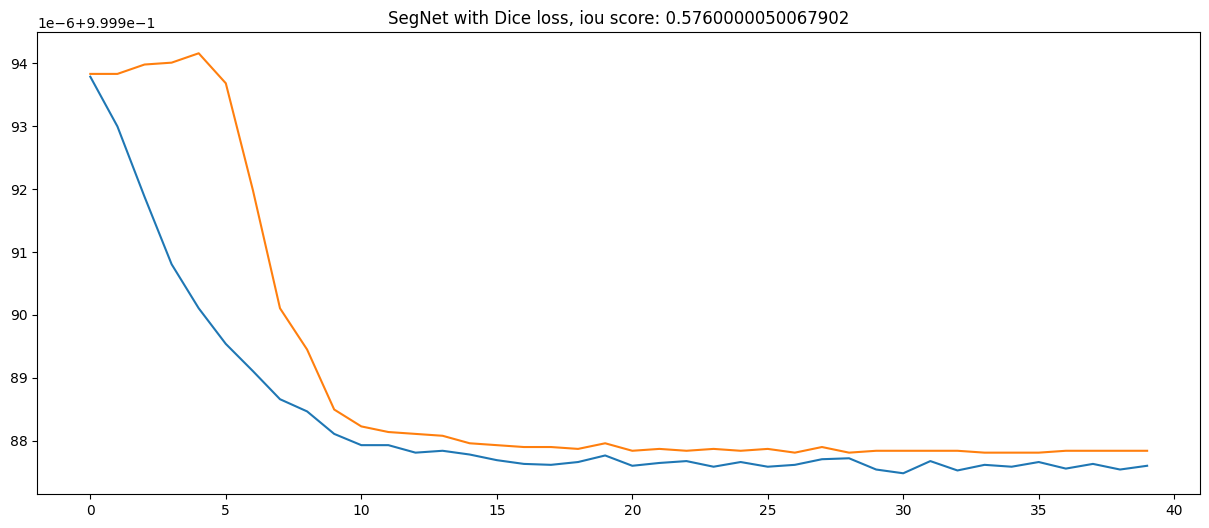

In [39]:
plt.plot(model_dice_tl)
plt.plot(model_dice_vl)
plt.title(f'SegNet with Dice loss, iou score: {model_dice_s}')

Text(0.5, 1.0, 'SegNet with Focal loss, iou score: 0.5780000388622284')

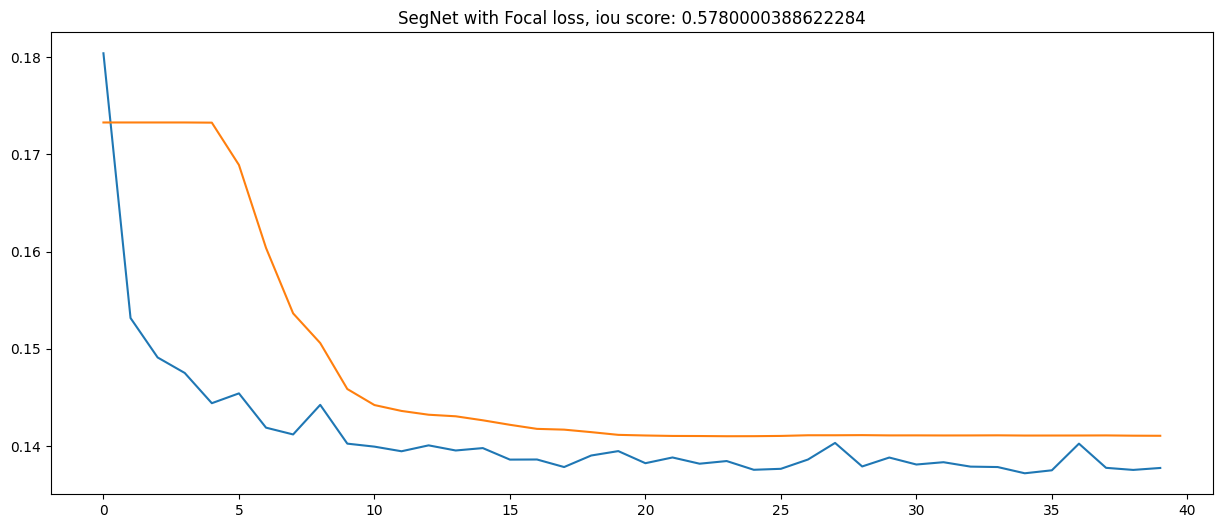

In [40]:
plt.plot(model_focal_tl)
plt.plot(model_focal_vl)
plt.title(f'SegNet with Focal loss, iou score: {model_focal_s}')

Text(0.5, 1.0, 'SegNet with BCE loss with lable smoothing loss, iou score: 0.6460000276565552')

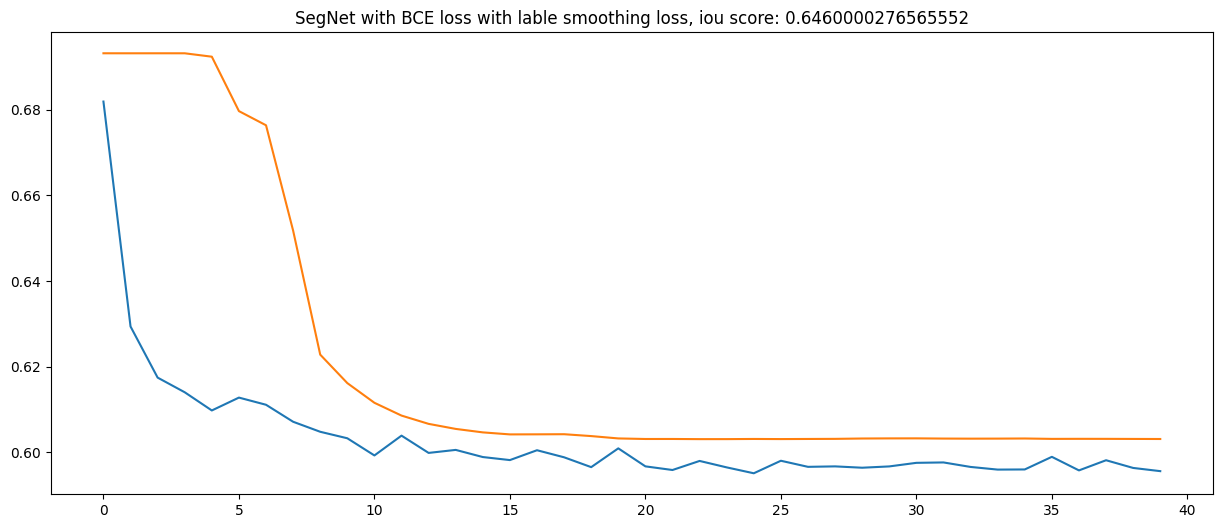

In [41]:
plt.plot(model_ls_tl)
plt.plot(model_ls_vl)
plt.title(f'SegNet with BCE loss with lable smoothing loss, iou score: {model_ls_s}')

Text(0.5, 1.0, 'U-Net with MaxUnpooling and BCE loss, iou score: 0.6479999721050262')

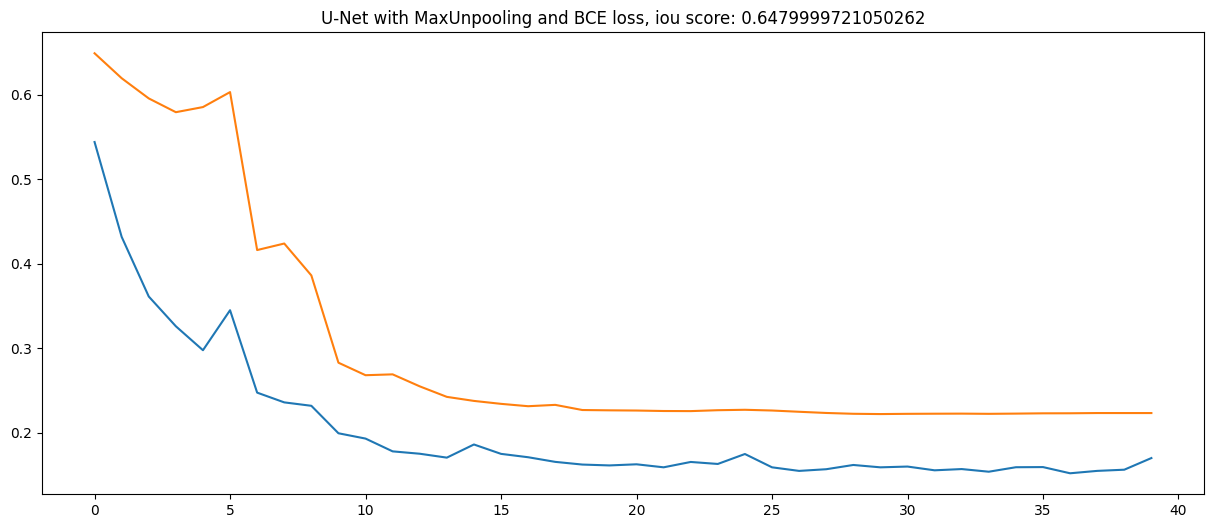

In [42]:
plt.plot(unet_model_tl)
plt.plot(unet_model_vl)
plt.title(f'U-Net with MaxUnpooling and BCE loss, iou score: {unet_model_s}')

Text(0.5, 1.0, 'U-Net with BCE loss with lable smoothing loss, iou score: 0.6099999845027924')

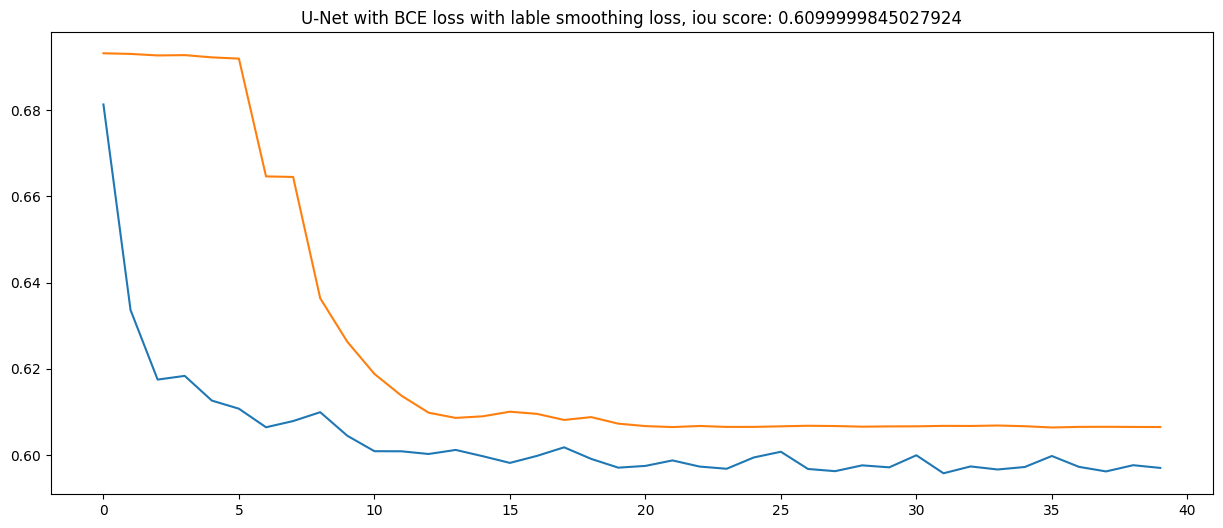

In [43]:
plt.plot(unet_dice_model_tl)
plt.plot(unet_dice_model_vl)
plt.title(f'U-Net with BCE loss with lable smoothing loss, iou score: {unet_dice_model_s}')

Text(0.5, 1.0, 'U-Net with NN UpSampling and BCE loss, iou score: 0.6380000114440918')

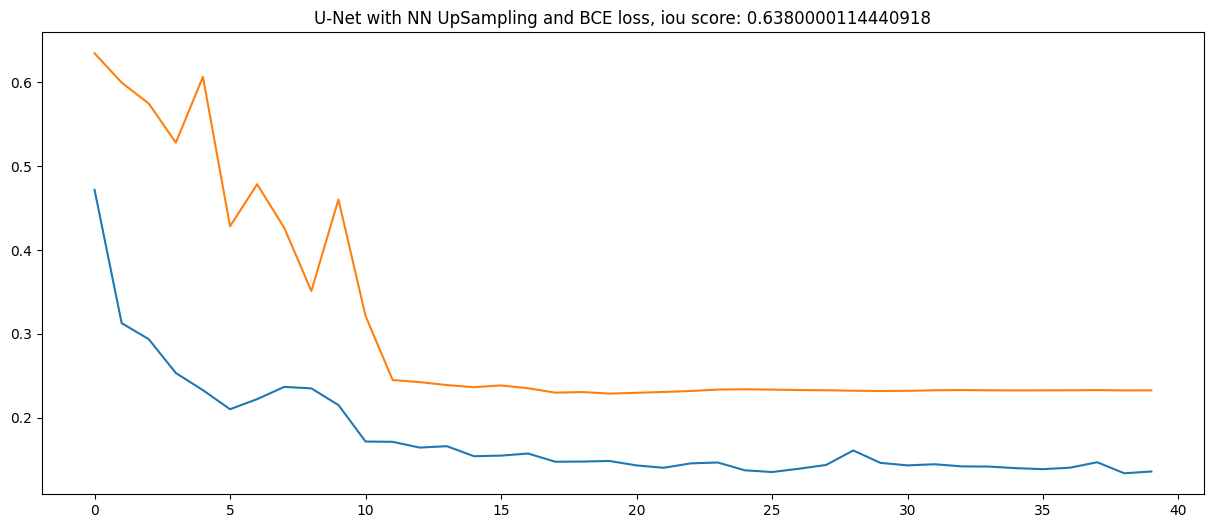

In [44]:
plt.plot(unet2_model_tl)
plt.plot(unet2_model_vl)
plt.title(f'U-Net with NN UpSampling and BCE loss, iou score: {unet2_model_s}')

Text(0.5, 1.0, 'U-Net with NN UpSampling and BCE loss with lable smoothing loss, iou score: 0.6159999966621399')

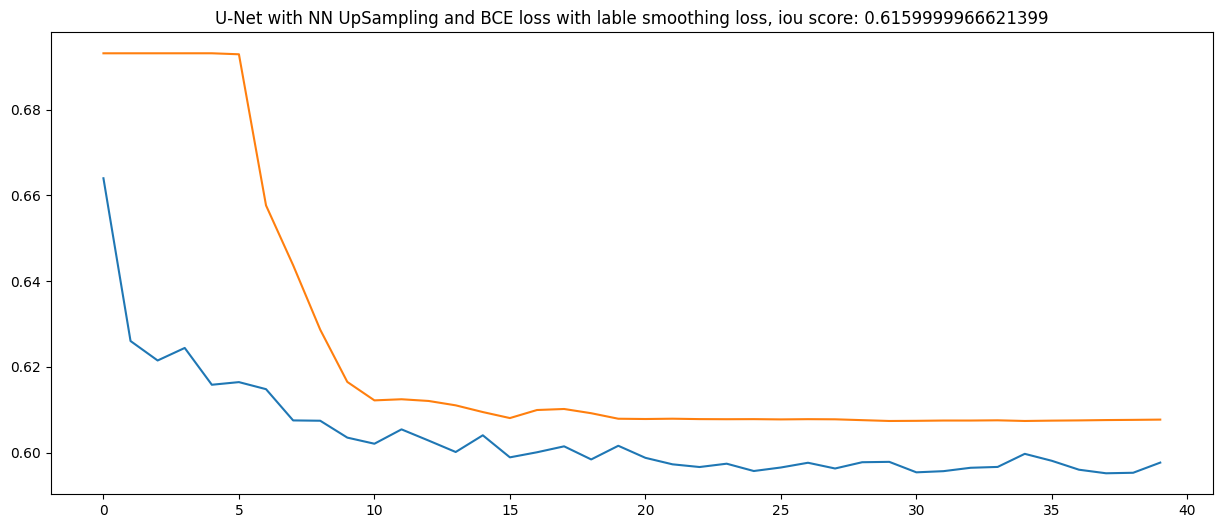

In [45]:
plt.plot(unet2_model_dice_tl)
plt.plot(unet2_model_dice_vl)
plt.title(f'U-Net with NN UpSampling and BCE loss with lable smoothing loss, iou score: {unet2_model_dice_s}')

Лучшей моделью по результатом экспериментов оказалась модель SegNet with BCE loss, iou score (IOU: 0.674). Для улучшения качества прогнозов в первую очередь необходимо увеличить глубину модели в слоях, чтобы избежать переобучения из-за маленького размера самой модели, увеличить размер модели до того масштаба, который бы позволял улавливать все паттерны в изображениях, а также осуществить оптимизацию гиперпараметров (в том числе подбор гиперпараметров для других функций потерь).